In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from time import time
from tqdm import tqdm

import numpy as np
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score, mean_absolute_percentage_error
from skimage.metrics import mean_squared_error, structural_similarity, peak_signal_noise_ratio

import keras
import tensorflow as tf

from utils import load_data
from pix2vid2 import make_model

msteps = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18]
NUM_REALIZATIONS = 1000
NX,  NY,  NZ = 64, 64, 1
NTT, NT1, NT2 = 40, 20, len(msteps)
HIDDEN = [16, 64, 256]

sec2year   = 365.25 * 24 * 60 * 60
Darcy      = 9.869233e-13
psi2pascal = 6894.76
co2_rho    = 686.5266
milli      = 1e-3
mega       = 1e6

def check_tf_gpu():
    sys_info = tf.sysconfig.get_build_info()
    kversion = keras.__version__
    version, cuda, cudnn = tf.__version__, sys_info["cuda_version"], sys_info["cudnn_version"]
    count = len(tf.config.experimental.list_physical_devices())
    name  = [device.name for device in tf.config.experimental.list_physical_devices('GPU')]
    print('-'*62)
    print('------------------------ VERSION INFO ------------------------')
    print('TF version: {} | Keras: {} | # Device(s) available: {}'.format(version, kversion, count))
    print('TF Built with CUDA? {} | CUDA: {} | cuDNN: {}'.format(tf.test.is_built_with_cuda(), cuda, cudnn))
    print(tf.config.list_physical_devices()[-1])
    print('-'*62+'\n')
    return None

check_tf_gpu()

--------------------------------------------------------------
------------------------ VERSION INFO ------------------------
TF version: 2.15.0 | Keras: 3.5.0 | # Device(s) available: 2
TF Built with CUDA? True | CUDA: 12.2 | cuDNN: 8
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
--------------------------------------------------------------



In [2]:
gt = sio.loadmat('grids/Gt.mat', simplify_cells=True)['Gt']
gtops = gt['cells']['z'].reshape(NX,NY,order='F')
gvols = gt['parent']['cells']['volumes'].reshape(NX,NY,order='F')
ghght = gt['cells']['H'].reshape(NX,NY,order='F')

deltatime = sio.loadmat('data/time_arr.mat', simplify_cells=True)['time_arr']
timesteps = np.cumsum(deltatime)
timesteps_inj = timesteps[:20]
timesteps_mon = timesteps[20:][msteps]
#timesteps_mon = timesteps[[19, 24, 29, 34, 39]]

print('timesteps: {} | deltatime: {}'.format(len(timesteps), np.unique(deltatime)))
print('injection: {}'.format(timesteps_inj))
print('monitoring: {}'.format(timesteps_mon))

timesteps: 40 | deltatime: [  0.5 100. ]
injection: [ 0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5  7.
  7.5  8.   8.5  9.   9.5 10. ]
monitoring: [ 110.  310.  510.  710.  910. 1110. 1310. 1510. 1710. 1910.]


In [3]:
datas, norms = load_data()
X_data, c_data, y1_data, y2_data = datas.values()

X: (1000, 64, 64, 5) | c: (1000, 20, 5)
y1: (1000, 20, 64, 64, 2) | y2: (1000, 20, 64, 64, 1)
porosity     - min: -0.62 | max: 2.36
logperm      - min: -2.20 | max: 2.49
wells        - min: 0.00 | max: 1.00
tops         - min: 0.00 | max: 1.00
volumes      - min: 0.00 | max: 1.00
controls     - min: 0.00 | max: 0.97
pressure_1   - min: 0.00 | max: 15.39
saturation_1 - min: 0.00 | max: 1.00
saturation_2 - min: 0.00 | max: 1.00


In [4]:
train_idx = np.load('models/training_idx.npy')
test_idx  = np.setdiff1d(range(len(X_data)), train_idx)

tridx = train_idx[:20]
teidx = test_idx[:20]

X_train  = tf.cast(X_data[tridx], tf.float32)
c_train  = tf.cast(c_data[tridx], tf.float32)
y1_train = tf.cast(y1_data[tridx], tf.float32)
y2_train = tf.cast(y2_data[tridx], tf.float32)

X_test  = tf.cast(X_data[teidx], tf.float32)
c_test  = tf.cast(c_data[teidx], tf.float32)
y1_test = tf.cast(y1_data[teidx], tf.float32)
y2_test = tf.cast(y2_data[teidx], tf.float32)

In [5]:
model_inj, model_mon = make_model(hidden=HIDDEN, nt1=NT1, nt2=NT2)

model_inj.load_weights('models/pix2vid-v2-inj.weights.h5')
model_mon.load_weights('models/pix2vid-v2-mon.weights.h5')

# parameters: 87,162,769 | 43,687,525


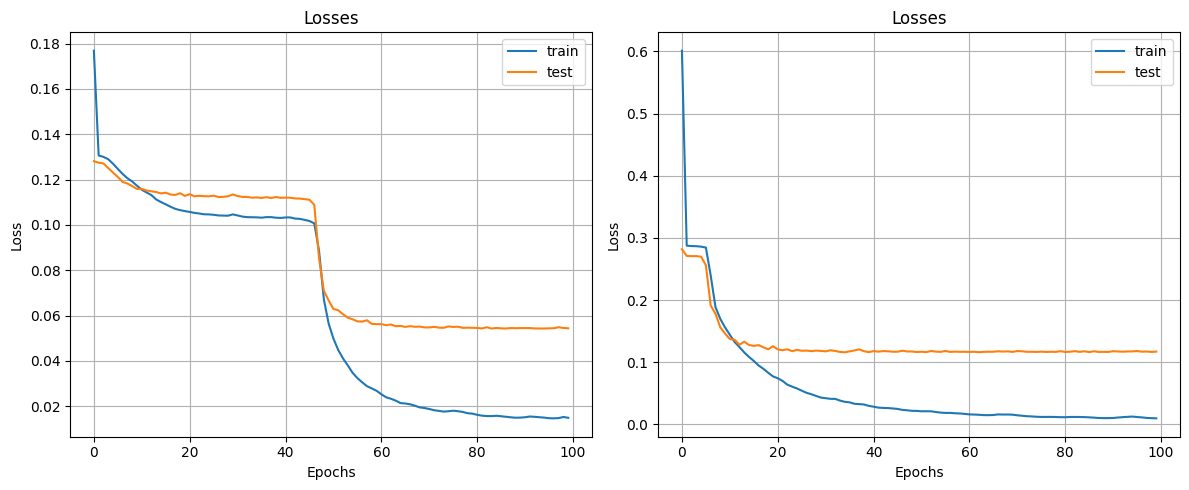

In [13]:
losses_inj = pd.read_csv('models/pix2vid-v2-inj.csv')
losses_mon = pd.read_csv('models/pix2vid-v2-mon.csv')

plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(losses_inj.index, losses_inj['loss'], label='train')
plt.plot(losses_inj.index, losses_inj['val_loss'], label='test')
plt.title('Losses'); plt.xlabel('Epochs'); plt.ylabel('Loss')
plt.legend(); plt.grid()

plt.subplot(122)
plt.plot(losses_mon.index, losses_mon['loss'], label='train')
plt.plot(losses_mon.index, losses_mon['val_loss'], label='test')
plt.title('Losses'); plt.xlabel('Epochs'); plt.ylabel('Loss')
plt.legend(); plt.grid()

plt.tight_layout()
plt.show()

In [14]:
y1_train_pred = model_inj.predict([X_train, c_train], verbose=False)
y2_train_pred = model_mon.predict([X_train, c_train], verbose=False)

y1_test_pred = model_inj.predict([X_test, c_test], verbose=False)
y2_test_pred = model_mon.predict([X_test, c_test], verbose=False)

y1_train_pred = np.array(y1_train_pred)
y2_train_pred = np.array(y2_train_pred)
y1_test_pred = np.array(y1_test_pred)
y2_test_pred = np.array(y2_test_pred)

X_train = np.array(X_train)
c_train = np.array(c_train)
y1_train = np.array(y1_train)
y2_train = np.array(y2_train)

X_test = np.array(X_test)
c_test = np.array(c_test)
y1_test = np.array(y1_test)
y2_test = np.array(y2_test)

print('Train - y1: {} | y2: {}'.format(y1_train_pred.shape, y2_train_pred.shape))
print('Test - y1: {} | y2: {}'.format(y1_test_pred.shape, y2_test_pred.shape))

I0000 00:00:1724270390.680441  555493 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Train - y1: (20, 20, 64, 64, 2) | y2: (20, 10, 64, 64, 1)
Test - y1: (20, 20, 64, 64, 2) | y2: (20, 10, 64, 64, 1)


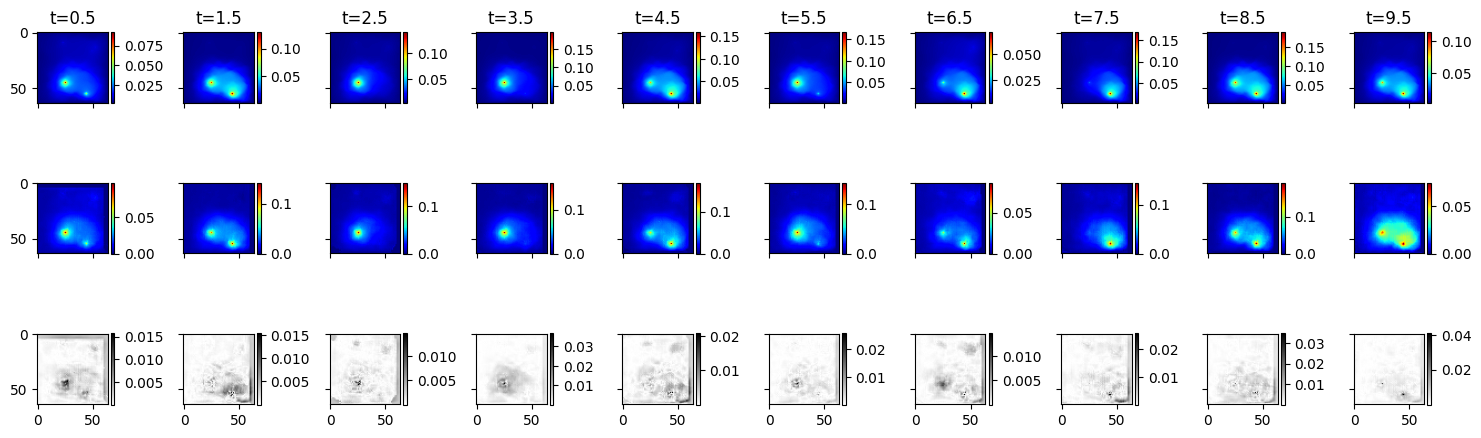

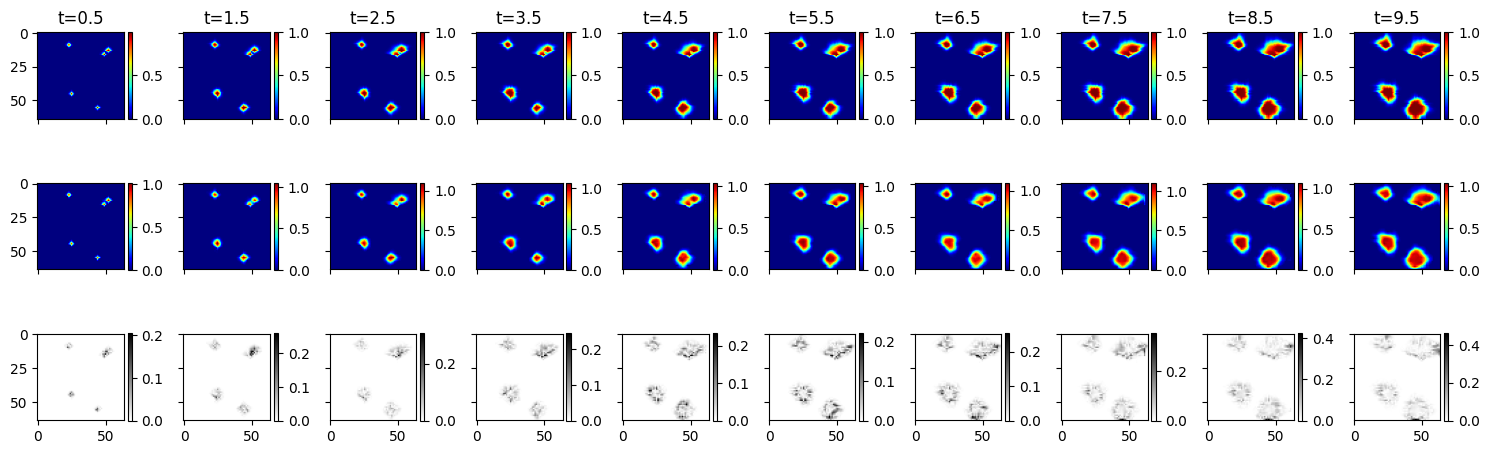

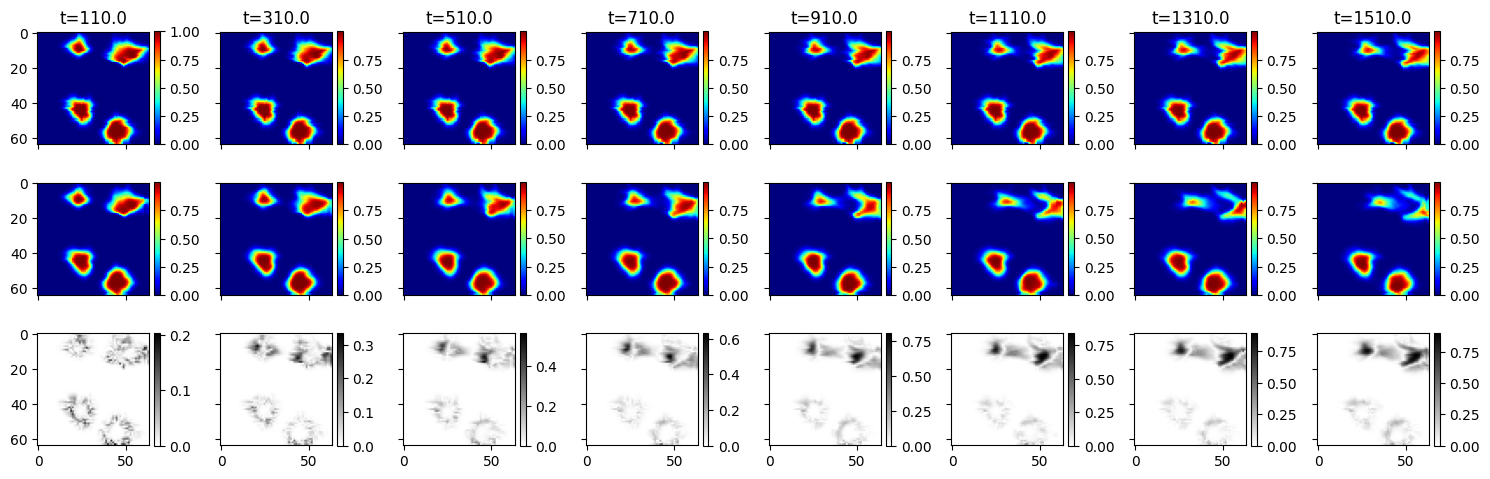

In [18]:
sample = 13

fig, axs = plt.subplots(3, 10, figsize=(15,5), sharex=True, sharey=True)
for j in range(10):
    ax1, ax2, ax3 = axs[0,j], axs[1,j], axs[2,j]
    k = j*2
    
    t = y1_train[sample, k, ..., 0]
    p = y1_train_pred[sample, k, ..., 0]
    e = np.linalg.norm(t.reshape(1,64,64)-p.reshape(1,64,64), axis=0)

    im1 = ax1.imshow(t, cmap='jet')
    im2 = ax2.imshow(p, cmap='jet')
    im3 = ax3.imshow(e, cmap='binary')
    [plt.colorbar(ii, pad=0.04, fraction=0.046) for ii in [im1,im2,im3]]
    ax1.set_title('t={}'.format(timesteps[k]))
    
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(3, 10, figsize=(15,5), sharex=True, sharey=True)
for j in range(10):
    ax1, ax2, ax3 = axs[0,j], axs[1,j], axs[2,j]
    k = j*2
    
    t = y1_train[sample, k, ..., 1]
    p = y1_train_pred[sample, k, ..., 1]
    e = np.linalg.norm(t.reshape(1,64,64)-p.reshape(1,64,64), axis=0)

    im1 = ax1.imshow(t, cmap='jet')
    im2 = ax2.imshow(p, cmap='jet')
    im3 = ax3.imshow(e, cmap='binary')
    [plt.colorbar(ii, pad=0.04, fraction=0.046) for ii in [im1,im2,im3]]
    ax1.set_title('t={}'.format(timesteps[k]))
    
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(3, 8, figsize=(15,5), sharex=True, sharey=True)
for j in range(8):
    ax1, ax2, ax3 = axs[0,j], axs[1,j], axs[2,j]

    t = y2_train[sample, j, ..., -1]
    p = y2_train_pred[sample, j, ..., -1]
    e = np.linalg.norm(t.reshape(1,64,64)-p.reshape(1,64,64), axis=0)

    im1 = ax1.imshow(t, cmap='jet')
    im2 = ax2.imshow(p, cmap='jet')
    im3 = ax3.imshow(e, cmap='binary')
    [plt.colorbar(ii, pad=0.04, fraction=0.046) for ii in [im1,im2,im3]]
    ax1.set_title('t={}'.format(timesteps_mon[j]))

plt.tight_layout()
plt.show()

***
# END